# MsPASS Getting Started Tutorial
## *Gary L. Pavlis and Yinzhi (Ian) Wang*
## Preliminaries
This tutorial assumes you have already done the following:
1.  Installed docker.
2.  Run the commmand `docker pull wangyinz/mspass_tutorial` 
3.  Launched docker using the tutorial container.
4.  Connected the container to get this tutorial running.

Our installation manual describes how to do that so we assume that was completed for you to get this far. 

Note MsPASS can also be run from a local copy of MsPASS installed through pip.   The only difference is in launching jupyter-notebook to get this tutorial running.   None of the tutorial should depend upon which approach you are using.  Further, if either approach was not done correctly you can expect python errors at the first import of a mspasspy module.  

## DEBUG
This and the next block are there only for debugging this notebook.   When restarting we need a simple block like the next one to just define the database. Add drop_collection lines if needed for cleanup

In [1]:
from mspasspy.db.database import Database
from mspasspy.db.client import Client as DBClient
dbclient=DBClient()
db=Database(dbclient,'getting_started',db_schema='mspass_lite.yaml', md_schema='mspass_lite.yaml')

from obspy import UTCDateTime


## Download data with obspy
### Overview of this section
MsPASS leans heavily on obspy.  In particular, in this section we will use obspy's web services functions to download waveform data, station metadata, and source metadata.  The approach we are using here is to stage these data to your local disk.   The dataset we will assemble is the mainshock and X days of larger aftershocks of the Tohoku earthquake.  The next section then covers how we import these data into the MsPASS framework to allow them to be processed.

### Select, download, and save source data in MongoDB
As noted we are focusing on the Tohoku earthquake and its aftershocks.  That earthquake's origin time is approximately  March 11, 2011, at 5:46:24 UTC.  The ISC epicenter is 38.30N, 142.50E.  We will then apply obspy's *get_events* function with the following time and area filters:
1.  Starttime March 11, 2011, 1 hour before the origin time.
2.  End time 7 days after the mainshock origin time.
3.  Epicenters within + or - 3 degrees Latitude
4.  Epicenters within + or - 3 degrees of Longitude. 
5.  Only aftershocks larger than 6.5
Here is the incantation in obspy to do that:

In [2]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client=Client("IRIS")
t0=UTCDateTime('2011-03-11T05:46:24.0')
starttime=t0-3600.0
endtime=t0+(7.0)*(24.0)*(3600.0)
lat0=38.3
lon0=142.5
minlat=lat0-3.0
maxlat=lat0+3.0
minlon=lon0-3.0
maxlon=lon0+3.0
minmag=6.5
cat=client.get_events(starttime=starttime,endtime=endtime,
        minlatitude=minlat,minlongitude=minlon,
        maxlatitude=maxlat,maxlongitude=maxlon,
        minmagnitude=minmag)
print(cat)

11 Event(s) in Catalog:
2011-03-12T01:47:16.160000Z | +37.590, +142.751 | 6.5 MW
2011-03-11T19:46:35.300000Z | +38.800, +142.200 | 6.5 mb
...
2011-03-11T05:51:20.500000Z | +37.310, +142.240 | 6.8 None
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW
To see all events call 'print(CatalogObject.__str__(print_all=True))'


We can save these easily into MongoDB for use in later processing with this simple command.

In [2]:
from mspasspy.db.database import Database
from mspasspy.db.client import Client as DBClient
dbclient=DBClient()
db=Database(dbclient,'getting_started',db_schema='mspass_lite.yaml', md_schema='mspass_lite.yaml')
n=db.save_catalog(cat)
print('number of event entries saved in source collection=',n)

number of event entries saved in source collection= 11


### Select, download, and save station metadata to MongoDB
We use a very similar procedure to download and save station data.   We again use obspy but in this case we use their *get_stations* function to construct what they call an "Inventory" object containing the station data. 

In [3]:
inv=client.get_stations(network='TA',starttime=starttime,endtime=endtime,
                        format='xml',channel='BH?',level='response')
net=inv.networks
x=net[0]
sta=x.stations
print("Number of stations retrieved=",len(sta))
print(inv)

Number of stations retrieved= 446
Inventory created at 2021-02-04T11:16:20.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-03-11...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			TA
		Stations (446):
			TA.034A (Hebronville, TX, USA)
			TA.035A (Encino, TX, USA)
			TA.035Z (Hargill, TX, USA)
			TA.109C (Camp Elliot, Miramar, CA, USA)
			TA.121A (Cookes Peak, Deming, NM, USA)
			TA.133A (Hamilton Ranch, Breckenridge, TX, USA)
			TA.134A (White-Moore Ranch, Lipan, TX, USA)
			TA.135A (Vickery Place, Crowley, TX, USA)
			TA.136A (Ennis, TX, USA)
			TA.137A (Heron Place, Grand Saline, TX, USA)
			TA.138A (Matatall Enterprise, Big Sandy, TX, USA)
			TA.139A (Bunkhouse Ranch, Marshall, TX, USA)
			TA.140A (Cam and Jess, Hughton, LA, USA)
			TA.141A (Papa Simpson, Farm, Arcadia, LA, USA)
			TA.142A (Monroe, LA, USA)
			TA.143A (Socs Landing, Pioneer, LA, USA)
			TA.214A (Organ 

The output shows we just downloaded the data form 446 TA stations that were running during this time period. Note a detail is if you want full response information stored in the database you need to specify *level='response'* as we have here.  The default is never right.  You need to specify level as at least "channel". 

We will now save these data to MongoDB with a very similar command to above: 

In [4]:
ret=db.save_inventory(inv,verbose=True)
print('save_inventory returned value=',ret)

net:sta:loc= TA : 034A :  for time span  2010-01-08T00:00:00.000000Z  to  2011-11-17T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 034A :  : BHE for time span  2010-01-08T00:00:00.000000Z  to  2011-11-17T17:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 034A :  : BHN for time span  2010-01-08T00:00:00.000000Z  to  2011-11-17T17:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 034A :  : BHZ for time span  2010-01-08T00:00:00.000000Z  to  2011-11-17T17:05:00.000000Z  added to channel collection
net:sta:loc= TA : 035A :  for time span  2010-01-12T00:00:00.000000Z  to  2011-11-14T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 035A :  : BHE for time span  2010-01-12T00:00:00.000000Z  to  2011-11-14T17:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 035A :  : BHN for time span  2010-01-12T00:00:00.000000Z  to  2011-11-14T17:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 035A :  : B

net:sta:loc:chan= TA : 233A :  : BHN for time span  2009-11-18T00:00:00.000000Z  to  2011-10-01T14:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 233A :  : BHZ for time span  2009-11-18T00:00:00.000000Z  to  2011-10-01T14:15:00.000000Z  added to channel collection
net:sta:loc= TA : 234A :  for time span  2009-11-17T00:00:00.000000Z  to  2011-10-01T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 234A :  : BHE for time span  2009-11-17T00:00:00.000000Z  to  2011-10-01T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 234A :  : BHN for time span  2009-11-17T00:00:00.000000Z  to  2011-10-01T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 234A :  : BHZ for time span  2009-11-17T00:00:00.000000Z  to  2011-10-01T16:45:00.000000Z  added to channel collection
net:sta:loc= TA : 236A :  for time span  2010-04-25T00:00:00.000000Z  to  2012-01-20T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 236A :  : B

net:sta:loc:chan= TA : 345A :  : BHN for time span  2011-03-17T00:00:00.000000Z  to  2012-01-18T22:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 345A :  : BHZ for time span  2011-03-17T00:00:00.000000Z  to  2012-01-18T22:45:00.000000Z  added to channel collection
net:sta:loc= TA : 346A :  for time span  2011-03-18T00:00:00.000000Z  to  2013-02-05T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 346A :  : BHE for time span  2011-03-18T00:00:00.000000Z  to  2013-02-05T17:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 346A :  : BHN for time span  2011-03-18T00:00:00.000000Z  to  2013-02-05T17:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 346A :  : BHZ for time span  2011-03-18T00:00:00.000000Z  to  2013-02-05T17:45:00.000000Z  added to channel collection
net:sta:loc= TA : 433A :  for time span  2009-11-10T00:00:00.000000Z  to  2011-10-02T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 433A :  : B

net:sta:loc:chan= TA : 533A :  : BHN for time span  2009-11-07T00:00:00.000000Z  to  2011-10-05T17:25:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 533A :  : BHZ for time span  2009-11-07T00:00:00.000000Z  to  2011-10-05T17:25:00.000000Z  added to channel collection
net:sta:loc= TA : 534A :  for time span  2009-11-06T00:00:00.000000Z  to  2011-10-05T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 534A :  : BHE for time span  2009-11-06T00:00:00.000000Z  to  2011-10-05T14:50:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 534A :  : BHN for time span  2009-11-06T00:00:00.000000Z  to  2011-10-05T14:50:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 534A :  : BHZ for time span  2009-11-06T00:00:00.000000Z  to  2011-10-05T14:50:00.000000Z  added to channel collection
net:sta:loc= TA : 535A :  for time span  2009-12-16T00:00:00.000000Z  to  2011-10-06T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 535A :  : B

net:sta:loc:chan= TA : 635A :  : BHZ for time span  2009-12-17T00:00:00.000000Z  to  2011-10-08T15:20:00.000000Z  added to channel collection
net:sta:loc= TA : 636A :  for time span  2010-01-26T00:00:00.000000Z  to  2011-11-09T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 636A :  : BHE for time span  2010-01-26T00:00:00.000000Z  to  2011-11-09T16:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 636A :  : BHN for time span  2010-01-26T00:00:00.000000Z  to  2011-11-09T16:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 636A :  : BHZ for time span  2010-01-26T00:00:00.000000Z  to  2011-11-09T16:35:00.000000Z  added to channel collection
net:sta:loc= TA : 637A :  for time span  2010-05-24T00:00:00.000000Z  to  2011-11-06T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 637A :  : BHE for time span  2010-05-24T00:00:00.000000Z  to  2011-11-06T19:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 637A :  : B

net:sta:loc:chan= TA : 934A :  : BHN for time span  2009-12-20T00:00:00.000000Z  to  2011-11-16T15:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 934A :  : BHZ for time span  2009-12-20T00:00:00.000000Z  to  2011-11-16T15:40:00.000000Z  added to channel collection
net:sta:loc= TA : 936A :  for time span  2010-01-13T00:00:00.000000Z  to  2011-11-18T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 936A :  : BHE for time span  2010-01-13T00:00:00.000000Z  to  2011-11-18T18:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 936A :  : BHN for time span  2010-01-13T00:00:00.000000Z  to  2011-11-18T18:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 936A :  : BHZ for time span  2010-01-13T00:00:00.000000Z  to  2011-11-18T18:35:00.000000Z  added to channel collection
net:sta:loc= TA : A04D :  for time span  2010-08-18T00:00:00.000000Z  to  2016-05-16T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : A04D :  : B

net:sta:loc:chan= TA : B33A :  : BHE for time span  2010-10-22T00:00:00.000000Z  to  2012-06-09T16:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : B33A :  : BHN for time span  2010-10-22T00:00:00.000000Z  to  2012-06-09T16:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : B33A :  : BHZ for time span  2010-10-22T00:00:00.000000Z  to  2012-06-09T16:15:00.000000Z  added to channel collection
net:sta:loc= TA : B34A :  for time span  2010-09-14T00:00:00.000000Z  to  2012-08-02T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : B34A :  : BHE for time span  2010-09-14T00:00:00.000000Z  to  2012-08-02T16:20:00.000000Z  added to channel collection
net:sta:loc:chan= TA : B34A :  : BHN for time span  2010-09-14T00:00:00.000000Z  to  2012-08-02T16:20:00.000000Z  added to channel collection
net:sta:loc:chan= TA : B34A :  : BHZ for time span  2010-09-14T00:00:00.000000Z  to  2012-08-02T16:20:00.000000Z  added to channel collection
net:sta:loc= TA : B3

net:sta:loc= TA : D32A :  for time span  2010-08-15T00:00:00.000000Z  to  2012-06-21T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : D32A :  : BHE for time span  2010-08-15T00:00:00.000000Z  to  2012-06-21T18:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : D32A :  : BHN for time span  2010-08-15T00:00:00.000000Z  to  2012-06-21T18:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : D32A :  : BHZ for time span  2010-08-15T00:00:00.000000Z  to  2012-06-21T18:30:00.000000Z  added to channel collection
net:sta:loc= TA : D33A :  for time span  2010-08-28T00:00:00.000000Z  to  2012-06-22T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : D33A :  : BHE for time span  2010-08-28T00:00:00.000000Z  to  2012-06-22T19:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : D33A :  : BHN for time span  2010-08-28T00:00:00.000000Z  to  2012-06-22T19:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : D33A :  : B

net:sta:loc:chan= TA : E36A :  : BHN for time span  2010-10-17T00:00:00.000000Z  to  2012-07-29T16:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : E36A :  : BHZ for time span  2010-10-17T00:00:00.000000Z  to  2012-07-29T16:05:00.000000Z  added to channel collection
net:sta:loc= TA : E37A :  for time span  2010-10-16T00:00:00.000000Z  to  2012-08-05T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : E37A :  : BHE for time span  2010-11-15T22:11:00.000000Z  to  2012-08-05T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : E37A :  : BHN for time span  2010-11-15T22:11:00.000000Z  to  2012-08-05T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : E37A :  : BHZ for time span  2010-11-15T22:11:00.000000Z  to  2012-08-05T16:45:00.000000Z  added to channel collection
net:sta:loc= TA : F04D :  for time span  2009-11-14T00:00:00.000000Z  to  2016-09-30T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : F04D :  : B

net:sta:loc:chan= TA : H04D :  : BHN for time span  2010-08-12T00:00:00.000000Z  to  2016-09-30T19:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : H04D :  : BHZ for time span  2010-08-12T00:00:00.000000Z  to  2016-09-30T19:30:00.000000Z  added to channel collection
net:sta:loc= TA : H17A :  for time span  2007-10-03T00:00:00.000000Z  to  2018-09-04T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : H17A :  : BHE for time span  2008-09-08T22:00:00.000000Z  to  2011-08-22T17:00:00.000000Z  added to channel collection
net:sta:loc:chan= TA : H17A :  : BHN for time span  2008-09-08T22:00:00.000000Z  to  2011-08-22T17:00:00.000000Z  added to channel collection
net:sta:loc:chan= TA : H17A :  : BHZ for time span  2008-09-08T22:00:00.000000Z  to  2011-08-22T17:00:00.000000Z  added to channel collection
net:sta:loc= TA : H25A :  for time span  2009-06-19T00:00:00.000000Z  to  2011-08-23T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : H25A :  : B

net:sta:loc:chan= TA : I37A :  : BHE for time span  2010-10-09T00:00:00.000000Z  to  2012-09-10T19:25:00.000000Z  added to channel collection
net:sta:loc:chan= TA : I37A :  : BHN for time span  2010-10-09T00:00:00.000000Z  to  2012-09-10T19:25:00.000000Z  added to channel collection
net:sta:loc:chan= TA : I37A :  : BHZ for time span  2010-10-09T00:00:00.000000Z  to  2012-09-10T19:25:00.000000Z  added to channel collection
net:sta:loc= TA : I38A :  for time span  2010-10-08T00:00:00.000000Z  to  2012-09-08T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : I38A :  : BHE for time span  2010-10-08T00:00:00.000000Z  to  2012-09-08T16:50:00.000000Z  added to channel collection
net:sta:loc:chan= TA : I38A :  : BHN for time span  2010-10-08T00:00:00.000000Z  to  2012-09-08T16:50:00.000000Z  added to channel collection
net:sta:loc:chan= TA : I38A :  : BHZ for time span  2010-10-08T00:00:00.000000Z  to  2012-09-08T16:50:00.000000Z  added to channel collection
net:sta:loc= TA : J0

net:sta:loc:chan= TA : K33A :  : BHE for time span  2010-07-20T00:00:00.000000Z  to  2012-05-12T15:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : K33A :  : BHN for time span  2010-07-20T00:00:00.000000Z  to  2012-05-12T15:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : K33A :  : BHZ for time span  2010-07-20T00:00:00.000000Z  to  2012-05-12T15:35:00.000000Z  added to channel collection
net:sta:loc= TA : K34A :  for time span  2010-07-28T00:00:00.000000Z  to  2012-04-26T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : K34A :  : BHE for time span  2010-07-28T00:00:00.000000Z  to  2012-04-26T15:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : K34A :  : BHN for time span  2010-07-28T00:00:00.000000Z  to  2012-04-26T15:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : K34A :  : BHZ for time span  2010-07-28T00:00:00.000000Z  to  2012-04-26T15:15:00.000000Z  added to channel collection
net:sta:loc= TA : K3

net:sta:loc:chan= TA : M30A :  : BHE for time span  2009-05-18T00:00:00.000000Z  to  2011-04-10T15:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : M30A :  : BHN for time span  2009-05-18T00:00:00.000000Z  to  2011-04-10T15:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : M30A :  : BHZ for time span  2009-05-18T00:00:00.000000Z  to  2011-04-10T15:30:00.000000Z  added to channel collection
net:sta:loc= TA : M31A :  for time span  2009-09-09T00:00:00.000000Z  to  2011-08-18T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : M31A :  : BHE for time span  2009-09-09T00:00:00.000000Z  to  2011-08-18T18:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : M31A :  : BHN for time span  2009-09-09T00:00:00.000000Z  to  2011-08-18T18:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : M31A :  : BHZ for time span  2009-09-09T00:00:00.000000Z  to  2011-08-18T18:40:00.000000Z  added to channel collection
net:sta:loc= TA : M3

net:sta:loc:chan= TA : N39A :  : BHN for time span  2010-11-16T00:00:00.000000Z  to  2012-12-05T20:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : N39A :  : BHZ for time span  2010-11-16T00:00:00.000000Z  to  2012-12-05T20:15:00.000000Z  added to channel collection
net:sta:loc= TA : N54A :  for time span  2010-11-06T00:00:00.000000Z  to  2016-04-19T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : N54A :  : BHE for time span  2010-11-06T00:00:00.000000Z  to  2015-10-21T21:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : N54A :  : BHN for time span  2010-11-06T00:00:00.000000Z  to  2015-10-21T21:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : N54A :  : BHZ for time span  2010-11-06T00:00:00.000000Z  to  2015-10-21T21:30:00.000000Z  added to channel collection
net:sta:loc= TA : N59A :  for time span  2010-11-08T00:00:00.000000Z  to  2016-04-19T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : N59A :  : B

net:sta:loc:chan= TA : P31A :  : BHE for time span  2009-05-18T00:00:00.000000Z  to  2011-04-05T16:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : P31A :  : BHN for time span  2009-05-18T00:00:00.000000Z  to  2011-04-05T16:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : P31A :  : BHZ for time span  2009-05-18T00:00:00.000000Z  to  2011-04-05T16:30:00.000000Z  added to channel collection
net:sta:loc= TA : P32A :  for time span  2009-09-19T00:00:00.000000Z  to  2011-08-23T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : P32A :  : BHE for time span  2009-09-19T00:00:00.000000Z  to  2011-08-23T18:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : P32A :  : BHN for time span  2009-09-19T00:00:00.000000Z  to  2011-08-23T18:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : P32A :  : BHZ for time span  2009-09-19T00:00:00.000000Z  to  2011-08-23T18:40:00.000000Z  added to channel collection
net:sta:loc= TA : P3

net:sta:loc:chan= TA : Q38A :  : BHN for time span  2010-12-03T00:00:00.000000Z  to  2012-10-20T15:20:53.000000Z  added to channel collection
net:sta:loc:chan= TA : Q38A :  : BHZ for time span  2010-12-03T00:00:00.000000Z  to  2012-10-20T15:20:53.000000Z  added to channel collection
net:sta:loc= TA : Q39A :  for time span  2010-12-01T00:00:00.000000Z  to  2012-09-28T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : Q39A :  : BHE for time span  2010-12-01T00:00:00.000000Z  to  2012-09-28T16:00:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Q39A :  : BHN for time span  2010-12-01T00:00:00.000000Z  to  2012-09-28T16:00:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Q39A :  : BHZ for time span  2010-12-01T00:00:00.000000Z  to  2012-09-28T16:00:00.000000Z  added to channel collection
net:sta:loc= TA : Q40A :  for time span  2010-12-06T00:00:00.000000Z  to  2012-09-13T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : Q40A :  : B

net:sta:loc= TA : S37A :  for time span  2010-06-21T00:00:00.000000Z  to  2012-03-03T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : S37A :  : BHE for time span  2010-06-21T00:00:00.000000Z  to  2012-03-03T15:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : S37A :  : BHN for time span  2010-06-21T00:00:00.000000Z  to  2012-03-03T15:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : S37A :  : BHZ for time span  2010-06-21T00:00:00.000000Z  to  2012-03-03T15:45:00.000000Z  added to channel collection
net:sta:loc= TA : S38A :  for time span  2010-12-15T00:00:00.000000Z  to  2012-10-27T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : S38A :  : BHE for time span  2010-12-15T00:00:00.000000Z  to  2012-07-29T18:00:00.000000Z  added to channel collection
net:sta:loc:chan= TA : S38A :  : BHN for time span  2010-12-15T00:00:00.000000Z  to  2012-07-29T18:00:00.000000Z  added to channel collection
net:sta:loc:chan= TA : S38A :  : B

net:sta:loc:chan= TA : U32A :  : BHN for time span  2009-10-24T00:00:00.000000Z  to  2012-02-27T23:59:59.000000Z  added to channel collection
net:sta:loc:chan= TA : U32A :  : BHZ for time span  2009-10-24T00:00:00.000000Z  to  2012-02-27T23:59:59.000000Z  added to channel collection
net:sta:loc= TA : U33A :  for time span  2009-10-25T00:00:00.000000Z  to  2011-08-31T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : U33A :  : BHE for time span  2009-10-25T00:00:00.000000Z  to  2011-08-31T13:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : U33A :  : BHN for time span  2009-10-25T00:00:00.000000Z  to  2011-08-31T13:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : U33A :  : BHZ for time span  2009-10-25T00:00:00.000000Z  to  2011-08-31T13:05:00.000000Z  added to channel collection
net:sta:loc= TA : U34A :  for time span  2009-10-23T00:00:00.000000Z  to  2011-09-02T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : U34A :  : B

net:sta:loc:chan= TA : W35A :  : BHE for time span  2010-04-15T00:00:00.000000Z  to  2012-02-01T19:25:00.000000Z  added to channel collection
net:sta:loc:chan= TA : W35A :  : BHN for time span  2010-04-15T00:00:00.000000Z  to  2012-02-01T19:25:00.000000Z  added to channel collection
net:sta:loc:chan= TA : W35A :  : BHZ for time span  2010-04-15T00:00:00.000000Z  to  2012-02-01T19:25:00.000000Z  added to channel collection
net:sta:loc= TA : W36A :  for time span  2010-04-13T00:00:00.000000Z  to  2012-02-01T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : W36A :  : BHE for time span  2010-04-13T00:00:00.000000Z  to  2011-09-09T15:59:59.000000Z  added to channel collection
net:sta:loc:chan= TA : W36A :  : BHN for time span  2010-04-13T00:00:00.000000Z  to  2011-09-09T15:59:59.000000Z  added to channel collection
net:sta:loc:chan= TA : W36A :  : BHZ for time span  2010-04-13T00:00:00.000000Z  to  2011-09-09T15:59:59.000000Z  added to channel collection
net:sta:loc= TA : W3

net:sta:loc:chan= TA : Y22D :  : BHZ for time span  2010-10-06T18:00:00.000000Z  to  2019-11-30T23:59:59.000000Z  added to channel collection
net:sta:loc= TA : Y33A :  for time span  2009-11-08T00:00:00.000000Z  to  2011-09-07T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : Y33A :  : BHE for time span  2009-11-08T00:00:00.000000Z  to  2011-09-07T16:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Y33A :  : BHN for time span  2009-11-08T00:00:00.000000Z  to  2011-09-07T16:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Y33A :  : BHZ for time span  2009-11-08T00:00:00.000000Z  to  2011-09-07T16:55:00.000000Z  added to channel collection
net:sta:loc= TA : Y34A :  for time span  2009-11-07T00:00:00.000000Z  to  2011-09-05T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : Y34A :  : BHE for time span  2009-11-07T00:00:00.000000Z  to  2011-09-05T16:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Y34A :  : B

We turned on verbose mode so the output is quite large, but we did that because it demonstrates what this Database method is doing.  It takes apart the complicated Inventory object obspy created from the stationxml data we downloaded and turns the result into a set of documents saved in the two main station metadata collections in MongoDB:  (1) *site* for station information and (2) *channel* that contains most of the same data as *site* but add a set of important additional information (notably component orientation and response data).  

We turn now to the task of downloading the waveform data.

### Download waveform data
The last download step for this tutorial is the one that will take the most time and consume the most disk space;  downloading the waveform data.   To keep this under control we keep only a waveform section spanning most of the body waves.   We won't burden you with the details of how we obtained the following rough numbers we use to define the waveform downloading parameters:

1.  The approximate distance from the mainshock epicenter to the center of the USArray in 2011 is 86.5 degrees.
2.  P arrival is expected about 763 s after the origin time
3.  S arrival is expected about 1400 s after the origin time

Since we have stations spanning the continent we will use the origin time of each event +P travel time (763 s) - 4 minutes as the start time.  For the end time we will use the origin time + S travel time (1400 s) + 10 minutes.  

This process will be driven by origin times from the events we downloaded earlier.   We could drive this by using the obspy *Catalog* object created above, but because saved the event data to the database we will use this opportunity to illustrate how that data is managed in MsPASS.

First, let's go over the data we saved in MongoDB.  We saved these data in a *collection* we call *source*.   For those familiar with relational databases a MongoDB "collection" plays a role similar to a table (relation) in a relational database.   A "collection" contains one or more "documents".  A "document" in MongoDB is analagous to a single tuple in a relational database.  The internal structure of a MongoDB is, however, very different being represented by binary storage of name-value pairs in a format they call BSON because the structure can be represented in human readable form as a common format today called JSON.   A key point for MsPASS to understand is the BSON (JSON) documents stored in MongoDB map directly into a python dict container.   We illustrate that in the next box by printing the event hypocenter data we downloaded above and then stored in MongoDB:

In [5]:
dbsource=db.source
cursor=dbsource.find()   # This says to retrieve and iterator overall all source documents
# The Cursor object MongoDB's find function returns is iterable
print('Event in tutorial dataset')
evlist=list()
for doc in cursor:
    lat=doc['latitude']
    lon=doc['longitude']
    depth=doc['depth']
    origin_time=doc['time']
    mag=doc['magnitude']
    # In MsPASS all times are stored as epoch times. obspy's UTCDateTime function easily converts these to 
    # a readable form in the print statment here but do that only for printing or where required to 
    # interact with obspy
    print(lat,lon,depth,UTCDateTime(origin_time),mag)
    evlist.append([lat,lon,depth,origin_time,mag])

Event in tutorial dataset
37.5898 142.7512 24.8 2011-03-12T01:47:16.160000Z 6.5
38.8 142.2 33.0 2011-03-11T19:46:35.300000Z 6.5
39.2219 142.5316 18.9 2011-03-11T11:36:40.030000Z 6.5
36.1862 141.6639 26.0 2011-03-11T08:19:27.470000Z 6.5
38.051 144.6297 19.8 2011-03-11T06:25:50.740000Z 7.6
36.0675 141.7291 23.0 2011-03-11T06:20:02.390000Z 6.5
36.0692 142.1388 23.0 2011-03-11T06:18:51.060000Z 6.6
36.2274 141.088 25.4 2011-03-11T06:15:37.570000Z 7.9
38.9847 143.4632 20.0 2011-03-11T06:08:32.540000Z 6.7
37.31 142.24 33.0 2011-03-11T05:51:20.500000Z 6.8
38.2963 142.498 19.7 2011-03-11T05:46:23.200000Z 9.1


Notice that we use python dict syntax to extract attributes like latitude ('lat' key) from "document" which acts like a python dict.  

We saved the core metadata attributes in a python list, *evlist*, to allow us to reduce the volume of data we will retrieve.  We'll keep just the three biggest events;  the mainshock and the two 7+ aftershocks.  We do that in the block below using a set container to define keepers.  The approach is a bit obscure and not the most efficient.  We could just use the list we just built to drive the processing in the next box, but we use the approach there to illustrate another example of how to loop over documents retrieved from MongoDB - a common thing you will need to do to work with MongoDB in MsPASS.

With that the loop below is similar to the simple print loop above, BUT requires an obscure parameter not usually discussed in the MongoDB documentation.   The problem we have to deal with is that the obspy web service downloader we are going to call in the loop below will take a while to complete (likely over an hour).  Long running processes interacting with MongoDB and using a "Cursor" object (the thing *find* returned) can fail and throw confusing messages from a timeout problem.  That is, a job will mysteriously fail with a message that does not always make the fundamental problem clear.  The solution is to create what some books call an "immortal cursor".   You will see this in the next box that does the waveform downloading as this line:
```
cursor=dbsource.find({},no_cursor_timeout=True)
```
where here we use an explicit "find all" with the (weird) syntax of "{}" and make the cursor immortal by setting no_cursor_timeout to True.

With that background here is the script to download data.  You might want to go grab a cup of coffee while this runs as it will take a while.  

In [6]:
from mspasspy.util.converter import Trace2TimeSeries

#db=Database(dbclient,'getting_started')
# We have to redefine the client from obspy to use their so called bulk downloader
from obspy.clients.fdsn import RoutingClient
client = RoutingClient("iris-federator")
# This uses the (admitted obscure) approach of a set container of keepers to reduce the download time
keepers=set()
keepers.add(4)
keepers.add(7)
keepers.add(10)

cursor=db.source.find({},no_cursor_timeout = True)
count=0
start_offset=763.0-4*60.0
end_offset=1400.0+10*60.0
i=0
for doc in cursor:
    if i in keepers: 
        origin_time=doc['time']
        # We need the ObjectId of the source to provide a cross reference to link our 
        # waveform data to the right source.  Better to do this now than later as association 
        # can be a big challenge
        id=doc['_id']
        
        print('Starting on event number',i,' with origin time=',UTCDateTime(origin_time))
        stime=origin_time+start_offset
        etime=origin_time+end_offset
        strm=client.get_waveforms(
            starttime=UTCDateTime(stime),
            endtime=UTCDateTime(etime),
            network='TA',
            channel='BH?',
            location='*'
        )
        # The output of get_waveforms is an obspy Stream object. Stream objects are iterable 
        # so we work through the group, converting each to a MsPASS TimeSeries, and then saving 
        # the results to the database.  
        for d in strm:
            d_mspass=Trace2TimeSeries(d)
            # Here is where we save the id linked to the source collection. 
            # We use a MsPASS convention that such metadata have name collection_id
            d_mspass['source_id'] = id
            #print('Saving data for sta=',d_mspass['sta'],' and chan=',d_mspass['chan'])
            db.save_data(d_mspass,include_undefined=True)   
            count += 1
    else:
        print('Skipping event number ',i,' with origin time=',UTCDateTime(origin_time))
    i += 1
print('Number of waveforms saved=',count)
    

Skipping event number  0  with origin time= 2011-03-11T05:46:23.200000Z
Skipping event number  1  with origin time= 2011-03-11T05:46:23.200000Z
Skipping event number  2  with origin time= 2011-03-11T05:46:23.200000Z
Skipping event number  3  with origin time= 2011-03-11T05:46:23.200000Z
Starting on event number 4  with origin time= 2011-03-11T06:25:50.740000Z
Skipping event number  5  with origin time= 2011-03-11T06:25:50.740000Z
Skipping event number  6  with origin time= 2011-03-11T06:25:50.740000Z
Starting on event number 7  with origin time= 2011-03-11T06:15:37.570000Z
Skipping event number  8  with origin time= 2011-03-11T06:15:37.570000Z
Skipping event number  9  with origin time= 2011-03-11T06:15:37.570000Z
Starting on event number 10  with origin time= 2011-03-11T05:46:23.200000Z
Number of waveforms saved= 3933


## Quick Look for QC
MsPASS has some basic graphics capabilities to display its standard data types.  We refer the reader to a the *BasicGraphics* tutorial for more details, but for now we just illustrate using the plotting for a quick look as a basic QC to verify we have what we were looking for.

The previous step used *save_data* to save the data we downloaded to MongoDB.   How it is stored is a topic for later, but here we'll retrieve some of that data and plot it to illustrate the value of abstracting the read and write operations.   Reading is slightly more complicated than writing one atomic object as we did above.  The reason is that we often want to do a database select operation to limit what we get.  This example illustrates some basics on MongoDB queries.  The reader is referred to extensive external documentation on MongoDB (books and many online sources) on this topic. 

Let's first grab the data for one station from all three events we saved.   This is a good illustration of the basic query mechanism used by MongoDB.  

In [2]:
from mspasspy.ccore.seismic import TimeSeriesEnsemble
sta='234A'
ensemble=TimeSeriesEnsemble()
ensemble['sta']=sta
query={ 'sta' : sta }
n=db.wf_TimeSeries.count_documents(query)
print('Trying to retrieve ',n,' TimeSeries objects for station=',sta)
curs=db.wf_TimeSeries.find(query)
for doc in curs:
    # With the current mspass_lite schema these extra options are required
    d=db.read_data(doc,load_history=False,include_undefined=True)
    ensemble.member.append(d)
print('Success:  number of members in this ensemble=',len(ensemble.member))    

Trying to retrieve  9  TimeSeries objects for station= 234A
Success:  number of members in this ensemble= 9


In [41]:
#debug delete this box when done
x=ensemble.member[0]
print(x)
if x.is_defined('source_id'):
    print('source_id is defined')

{'_fdsnws_dataselect_url': 'http://service.iris.edu/fdsnws/dataselect/1/query', '_format': 'MSEED', '_id': ObjectId('601bda4acfc6b8d3a01cb207'), 'calib': 1.000000, 'chan': 'BHE', 'delta': 0.025000, 'endtime': 1299826750.000000, 'gridfs_id': ObjectId('601bda4acfc6b8d3a01cb208'), 'mseed': {'dataquality': 'M', 'number_of_records': 26, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 142506496}, 'net': 'TA', 'npts': 59081, 'sampling_rate': 40.000000, 'source_id': ObjectId('601bce167c394740be52b665'), 'sta': '234A', 'starttime': 1299825273.000000, 'storage_mode': 'gridfs', 'time_standard': 'UTC', 'utc_convertible': True}
source_id is defined


Notice that like *save_data* the default usage of *read_data* is about as simple as it gets;  you just point the reader at the document abstraction (the *doc* symbol) that defines a particular waveform and it is retrieved.  

A second point this example is a key concept in MsPASS.   We define two data objects as *Atomic* that we refer to as *TimeSeries* and *Seismogram*.   We are working with *TimeSeries* objects here because they were born from single channel records downloaded with FDSN web services.   Later in this tutorial we will convert the data now defined by the wf_TimeSeries collection to *Seismogram* objects and write them into a wf_Seismogram collection.  We call *Timeseries* and *Seismogram* object "Atomic" because for most processing they should be considered a single thing.  (For more experienced programs, note that in reality like atoms these data objects are made of subatomic particles with a class inheritance structure but the energy barrier to pull them apart is significant.)  Many functions, however, need the concept we call an *Ensemble*.   These are a collection of atomic objects that have a generic relationship.   Examples are "shot gathers", "CMP gathers", and "common receiver gathers" concepts used in seismic reflection processing.  An *Ensemble* is a container that can be any of those.  Your workflow needs to be aware at all times what is in any ensemble and be sure the requirements of an algorithm are met.  (e.g. in reflection processing you will junk if you think an ensemble is a NMO corrected CMP gather and the data are actually a raw shot gather).  

There are two named types of ensemble containers; one for each atomic data object.  They are called *TimeSeriesEnsemble* and *SeismogramEnsemble* for containers of *TimeSeries* and *Seismogram* object respectively.   In both cases the seismic data components are stored in simple list-like container defined with the symbol *member*. The container also can act a bit like a python dict to store global metadata related to the ensemble. We will refer to that container here as the *ensemble metadata*.   Our example above can be thought of as a common receiver gather for TA station 234A.  Hence, we post that name with the key *sta* with the line `ensemble['sta']=sta`.    That model should be the norm for any ensemble.   That is, the ensemble metadata should normally contain a set of one or more key-value pairs that at least provide a  hint at the ensemble contents.  Here that is the station name, but we could add other data like the stations coordinates.  We defer that to below where that data becomes necessary.  

With that background let's plot these data.  Here we illustrate the use of basic plotting routines in MsPASS but we note any python graphic package can be use for plotting these data if you understand the data structures.  We provide the *SeismicPlotter* class here as a convenience.  A valuable addition for community development is extensions of our basic graphics module or alternative plotting modules.

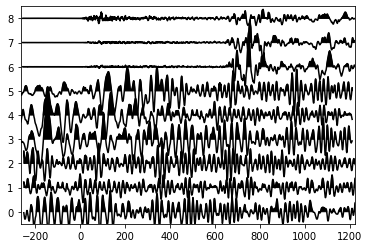

In [9]:
from mspasspy.graphics import SeismicPlotter
plotter=SeismicPlotter(normalize=True)
# TODO  default wtvaimg has a bug and produces a 0 height plot - wtva works for now
plotter.change_style('wtva')
plotter.plot(ensemble)

Again, about as simple as it gets.  This and the earlier examples illustrate a key design goal we had for MsPASS:  make the package as simple to use for beginners as possible.   The only trick we used here was to turn on automatic scaling (`normalize=True` line in the constructor) that is turned off by default.  Scaling is essential here since we are mixing data from events with different magnitudes.  

The plots shows the mainshock record as the top 3 signals.   Below that are sets of 3 signals from the other 2 large events in our data subset defined as "keepers".  Notice how the 3 sets of signals are offset in time.  The data are plotted that way because our the data time stamp is coordinated universal time (UTC) and they are being plotted in their actual timing position.   The topic of a UTC time standard and how MsPASS handles this is a unique feature of MsPASS and is the topic of next section.

The SeismicPlotter has a fair amount of additional functionality.  See the BasicGraphics tutorial to learn some of that functionality.

## UTC and Relative Time
A unique feature of MsPASS is that we aimed to make it generic by supporting multiple time standards.  MsPASS currently supports two time standards we refer to with the name keys *UTC* and *Relative*.   The first, *UTC*, is well understood by all seismologists who work with any modern data.  UTC is a standard abbreviation for coordinated univeral time, which is the time standard used on all modern data loggers.  It is important to recognize that unlike obspy we store all UTC times internally as "unix epoch times".  Epoch times are the number of seconds in UTC since the first instant of the year 1970.  We use only epoch times internally as it vastly simplifies storage of time attributes since they can be stored as a standard python float (always a 64 bit real number in python) that causes no complications in storage to MongoDB.  It also vastly simpifies computing time differences, which is a very common thing in data processing.   To convert UTC times to a human readable form we suggest using the obspy UTCDateTime class as we did above.  The inverse (converting a UTC date string to an epoch time) is simple with the timestamp method of UTCDateTime.  Some wrapped obspy functions require UTCDateTime objects but all database times are stored as floats. Most obspy function, like the web service functions we used above, use the UTCDateTime class to define.  The point is be to be cautious about what time arguments mean to different functions.

The idea of a *Relative* time is well known to anyone who has done seismic reflection processing.   Experienced SAC users will also understand the concept through a different mechanism that we generalize.  Time 0 for seismic reflection data ALWAYS means the time that the "shot" was fired.  That is a type example of what we mean by *Relative* time.   Earthquake data can be converted to the same concept by setting time zero for each signal to the origin time of the event.   SAC users will recognize that idea as the case of the "O" definition of the data's time stamp.   Our *Relative* time, in fact, is a generalization of SAC's finite set of definitions for the time stamp for one of their data files like Tn, B, O, etc.   *Relative* just means the data are relative to some arbitrary time stamp that we refer to internally as *t0_shift*.  It is the user's responsibility to keep track of what *t0_shift* means for your data and whether that reference is rational for the algorithm being run.  TimeSeries and Seismogram objects keep track of *t0_shift* and the reference can be shifted to a different time if desired through combinations of three different methods:  *rtoa* (switch from Relative to Absolute=UTC), *ator* (switch from Absolute(UTC) to Relative), and *shift* that is used to apply an relative time shift.   

In this next block we take the ensemble we created above and apply a time shift to put 0 at the predicted P wave arrival time.  

In [3]:
# We make a deep copy with this mechanism so we can restore raw data later
enscpy=TimeSeriesEnsemble(ensemble)
i=0
for d in ensemble.member:
    print('member ',i,' input t0 time=',UTCDateTime(d.t0))
    d.ator(d.t0)
    print('member ',i,' how has time 0=',d.t0)
    i+=1

member  0  input t0 time= 2011-03-11T06:34:33.000000Z
member  0  how has time 0= 0.0
member  1  input t0 time= 2011-03-11T06:34:33.024998Z
member  1  how has time 0= 0.0
member  2  input t0 time= 2011-03-11T06:34:33.024998Z
member  2  how has time 0= 0.0
member  3  input t0 time= 2011-03-11T06:24:20.000000Z
member  3  how has time 0= 0.0
member  4  input t0 time= 2011-03-11T06:24:20.024998Z
member  4  how has time 0= 0.0
member  5  input t0 time= 2011-03-11T06:24:20.000000Z
member  5  how has time 0= 0.0
member  6  input t0 time= 2011-03-11T05:55:06.000000Z
member  6  how has time 0= 0.0
member  7  input t0 time= 2011-03-11T05:55:06.000000Z
member  7  how has time 0= 0.0
member  8  input t0 time= 2011-03-11T05:55:06.000000Z
member  8  how has time 0= 0.0


Notice how the times changed from an offset from the origin time we used for downloading to 0.   We can see this effect graphically in the next box.  

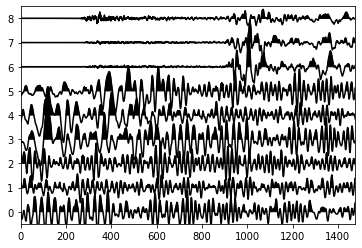

In [34]:
plotter.plot(ensemble)

Note that now the time axis starts at 0, BUT that is Relative time.  Here that time is a fixed offset from the origin time we obtained form the hypocenter origin time for each event.  

Those signals are ugly because these aftershocks are buried in the long period coda of the mainshock.  That should be clear from the UTC time plot we first made where the bottom six signals overlap, a common problem that presents a huge problem in some processing frameworks.   Let's plot this again with a bandpass filter applied.

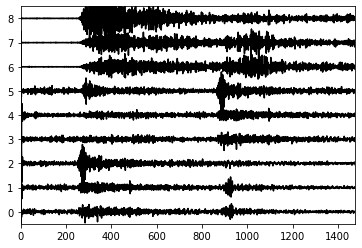

In [35]:
from mspasspy.algorithms.signals import filter
filter(ensemble,'bandpass',freqmin=0.2,freqmax=2.0)
plotter.plot(ensemble)

In [36]:
#debug cell
print(len(enscpy.member))
x=enscpy.member[0]
print(x)

9
{'_fdsnws_dataselect_url': 'http://service.iris.edu/fdsnws/dataselect/1/query', '_format': 'MSEED', '_id': ObjectId('601bda4acfc6b8d3a01cb207'), 'calib': 1.000000, 'chan': 'BHE', 'delta': 0.025000, 'endtime': 1299826750.000000, 'gridfs_id': ObjectId('601bda4acfc6b8d3a01cb208'), 'mseed': {'dataquality': 'M', 'number_of_records': 26, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 142506496}, 'net': 'TA', 'npts': 59081, 'sampling_rate': 40.000000, 'source_id': ObjectId('601bce167c394740be52b665'), 'sta': '234A', 'starttime': 1299825273.000000, 'storage_mode': 'gridfs', 'time_standard': 'UTC', 'utc_convertible': True}


In [4]:
# Next step is to load source and station coordinates
from mspasspy.preprocessing.seed.ensembles import load_source_data_by_id
ensemble=TimeSeriesEnsemble(enscpy)
for d in ensemble.member:
    d=load_source_data_by_id(db,d)
    print(d)
    net=d['net']
    sta=d['sta']
    chan=d['chan']
    # loc is sometimes undefined
    if d.is_defined('loc'):
        loc=d['loc']
    else:
        loc=None
    doc=db.get_seed_channel(net,sta,chan,loc,time=d.t0)
    d['channel_lat']=doc['latitude']
    d['channel_lon']=doc['longitude']
    d['channel_elev']=doc['elevation']
    d['channel_hang']=doc['hang']
    d['channel_vang']=doc['vang']
    d['channel_id']=doc['_id']


{'_fdsnws_dataselect_url': 'http://service.iris.edu/fdsnws/dataselect/1/query', '_format': 'MSEED', '_id': ObjectId('601bda4acfc6b8d3a01cb207'), 'calib': 1.000000, 'chan': 'BHE', 'delta': 0.025000, 'endtime': 1299826750.000000, 'gridfs_id': ObjectId('601bda4acfc6b8d3a01cb208'), 'mseed': {'dataquality': 'M', 'number_of_records': 26, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 142506496}, 'net': 'TA', 'npts': 59081, 'sampling_rate': 40.000000, 'source_depth': 19.800000, 'source_id': ObjectId('601bce167c394740be52b665'), 'source_lat': 38.051000, 'source_lon': 144.629700, 'source_time': 1299824750.740000, 'sta': '234A', 'starttime': 1299825273.000000, 'storage_mode': 'gridfs', 'time_standard': 'UTC', 'utc_convertible': True}
{'_fdsnws_dataselect_url': 'http://service.iris.edu/fdsnws/dataselect/1/query', '_format': 'MSEED', '_id': ObjectId('601bda4acfc6b8d3a01cb20b'), 'calib': 1.000000, 'chan': 'BHN', 'delta': 0.025000, 'endtime': 1299826749.999998, 'gridfs_id

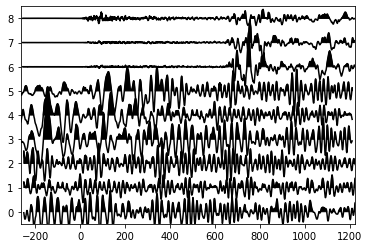

In [10]:
from mspasspy.algorithms.window import WindowData
from mspasspy.ccore.seismic import TimeWindow
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees

# This a time window in time relative to P arrival around 
# which we cut each waveform
cutwin=TimeWindow(-10.0,300.0)

for d in ensemble.member:
    stalat=d['channel_lat']
    stalon=d['channel_lon']
    srclat=d['source_lat']
    srclon=d['source_lon']
    depth=d['source_depth']
    otime=d['source_time']
    georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)
    # obspy's function we just called returns distance in m in element 0 of a tuple
    # their travel time calculator it is degrees so we need this conversion
    dist=kilometers2degrees(georesult[0]/1000.0)
    arrivals=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=dist,phase_list=['P'])
    d.rtoa()
    # Arrivals are returned in time order 0 is always the first arrival
    d.ator(otime+arrivals[0].time)
    d=WindowData(d,cutwin)
    
plotter.plot(ensemble)

## Creating Seismogram Objects
This section will run the bundle code to populate the wf_Seismogram collection.   Cannot function until the source_id problem is fixed.  Basic algorithm shown will be:
1.  find all source_ids
2.  foreach source_id
    * read ensmble 
    * run bundle_seed_data
    * write ensemble to db
    
Here is a start

In [26]:
from mspasspy.algorithms.bundle import bundle_seed_data
srcids=db.wf_TimeSeries.distinct('source_id')
for sid in srcids:
    query={'source_id' : sid }
    nd=db.wf_TimeSeries.count_documents(query)
    cursor=db.wf_TimeSeries.find( {'source_id' : sid} )
    ensemble=TimeSeriesEnsemble(nd)
    for doc in cursor:
        d=db.read_data(doc)
        ensemble.member.append(d)
    ens3c=bundle_seed_data(ensemble)
    db.save_ensemble(ens3c)

11


## Parallel Processing
This section will apply a workflow to the entire downloaded data set.  Pretty basic one driven by wf_TimeSeries collection.  Thinking:
1. parallel reader
2. detrend
3. filter
4. cut around P times (means might need a block earlier to post arrival_time to each wf document.  Might be a good lesson in foreign undefined metadata.